In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [2]:
df = pd.read_csv("1000_Binary Dataframe.csv")
df.head(n=5)

,Unnamed: 0,exists,eye_side,level,path,patient_id,level_cat
0,0,True,left,0,../input/diabetic-retinopathy-detection/10_lef...,10,[1. 0.]
1,1,True,right,0,../input/diabetic-retinopathy-detection/10_rig...,10,[1. 0.]
2,2,True,left,0,../input/diabetic-retinopathy-detection/13_lef...,13,[1. 0.]
3,3,True,right,0,../input/diabetic-retinopathy-detection/13_rig...,13,[1. 0.]
4,8,True,left,0,../input/diabetic-retinopathy-detection/17_lef...,17,[1. 0.]


In [3]:
df.shape

(1000, 7)

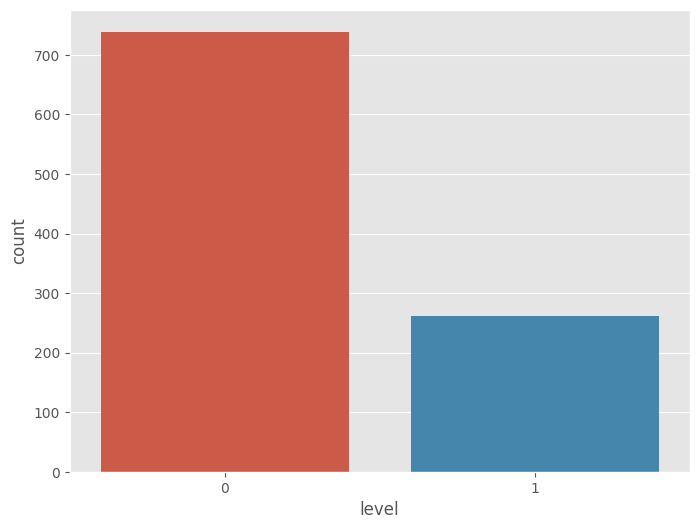

In [4]:
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
sns.countplot(data=df,x = 'level')
plt.show()

In [5]:
images_264 = np.load('1000_Binary_images_data_264.npz')
X_264=images_264['a']
y=df['level'].values
print(X_264.shape)
print(y.shape)

(1000, 209088)
(1000,)


In [6]:
print("Shape before reshaping X_264" +str(X_264.shape))
X_264=X_264.reshape(1000,264,264,3)
print("Shape after reshaping X_264" +str(X_264.shape))

Shape before reshaping X_264(1000, 209088)
Shape after reshaping X_264(1000, 264, 264, 3)


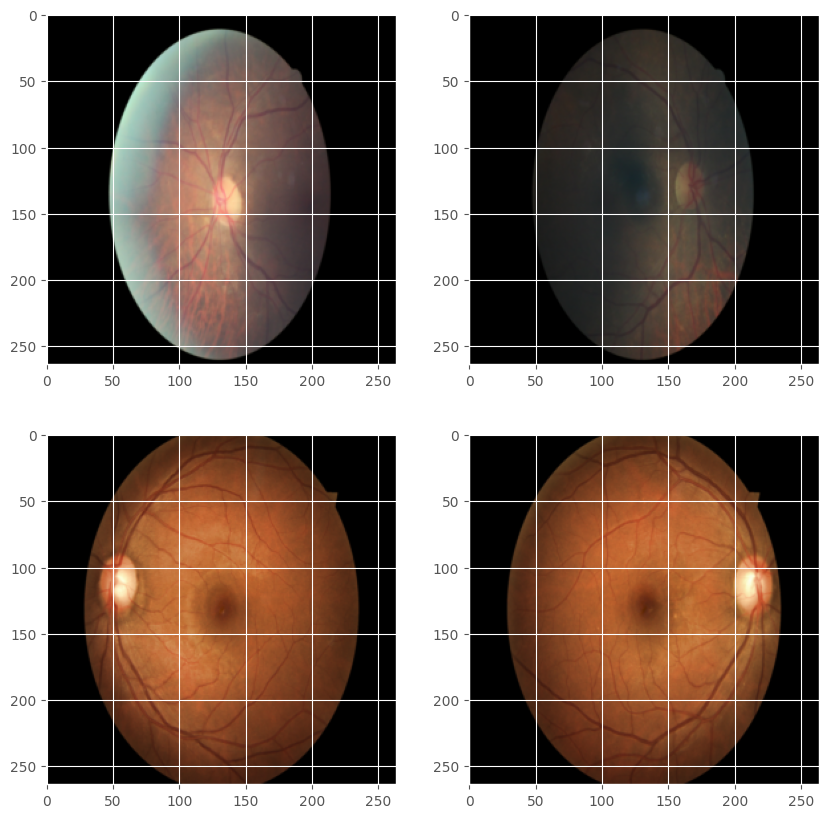

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(X_264[0])
plt.subplot(2,2,2)
plt.imshow(X_264[1])
plt.subplot(2,2,3)
plt.imshow(X_264[2])
plt.subplot(2,2,4)
plt.imshow(X_264[3])
plt.show()

In [8]:
from keras.models import load_model
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.utils import CustomObjectScope


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

with CustomObjectScope({'iou': iou,'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("model3.h5")
X_seg = []
for i in X_264:
    z = i
    scale_percent = 194 # percent of original size
    width = int(z.shape[1] * scale_percent / 100)
    height = int(z.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(z, dim, interpolation = cv2.INTER_AREA)
#     X_512 = np.append(X_512,np.array(resized))
    x = resized.astype(np.float32)
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    scale_percent = 100 # percent of original size
    width = int(z.shape[1] * scale_percent / 100)
    height = int(z.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(z, dim, interpolation = cv2.INTER_AREA)

    X_seg.append(resized)

1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


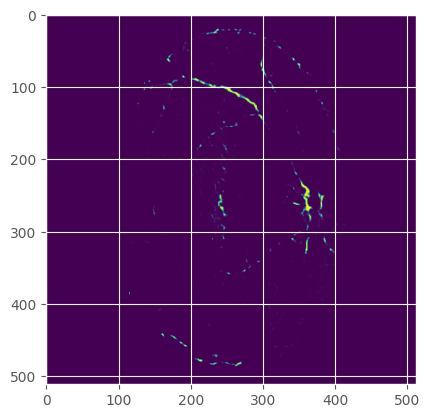

In [9]:
plt.imshow(prediction)

In [10]:
X=np.array(X_264)
Y=np.array(y)
Y=to_categorical(Y,2)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1, test_size=0.4, random_state=101)
print(len(x_train),len(x_val),len(x_test))

700 120 180


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
augment = ImageDataGenerator(
                             rotation_range=20,
                              width_shift_range=0.01,
                              height_shift_range=0.01,
                              horizontal_flip=False,
                              vertical_flip=False,
                            )
augment.fit(x_train)

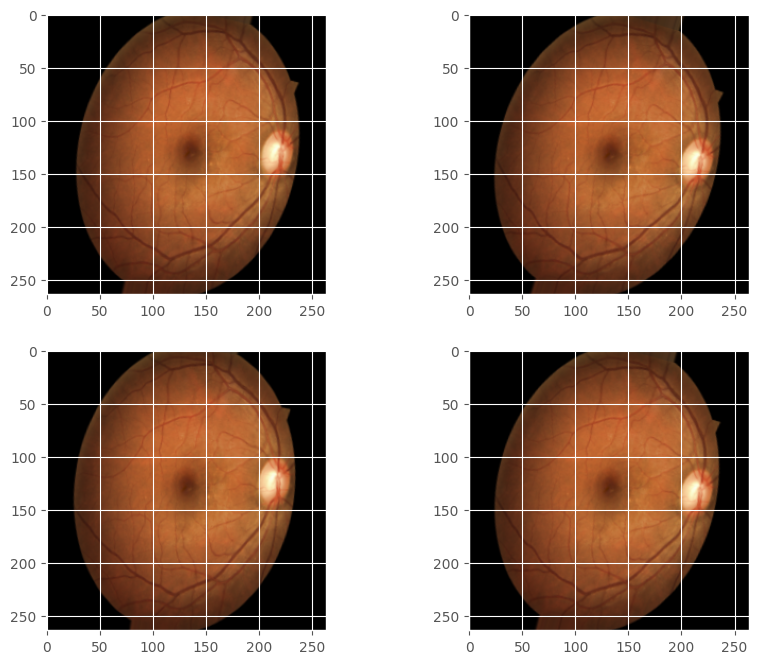

In [13]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,2)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,3)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,4)
plt.imshow(augment.random_transform(X_264[3]))
plt.show()

In [14]:
model = ResNet50(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

In [15]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 264, 264, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 270, 270, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 132, 132, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 132, 132, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 66, 66, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 66, 66, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 66, 66, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 33, 33, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 33, 33, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 33, 33, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 17, 17, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 17, 17, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 17, 17, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 17, 17, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 17, 17, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 17, 17, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 17, 17, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 17, 17, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 17, 17, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 17, 17, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 9, 9, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 9, 9, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 9, 9, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 9, 9, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [16]:
for ix in range(len(model.layers)):
    print(ix,model.layers[ix])

0 <keras.src.engine.input_layer.InputLayer object at 0x000002A519779490>
1 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002A518089160>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A51518D640>
3 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A51A69F820>
4 <keras.src.layers.core.activation.Activation object at 0x000002A5196DC160>
5 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002A51A665DF0>
6 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002A51D1F8D90>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A51D1F8E20>
8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A51A675250>
9 <keras.src.layers.core.activation.Activation object at 0x000002A51D208C70>
10 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A51D1F89D0>
11 <keras.src.layers.normalization.batch_normalization.BatchNormaliza

In [17]:
for layer in model.layers[:169]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [18]:
av1 = Flatten()(model.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_resnet = Model(model.input,fc3)
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 264, 264, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 270, 270, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 132, 132, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 132, 132, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 66, 66, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 66, 66, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 66, 66, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 33, 33, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 33, 33, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 33, 33, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 17, 17, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 17, 17, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 17, 17, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 17, 17, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 17, 17, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 17, 17, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 17, 17, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 17, 17, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 17, 17, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 17, 17, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 9, 9, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 9, 9, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 9, 9, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 9, 9, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [19]:
adam = Adam(learning_rate=0.0001)
model_resnet.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [20]:
filepath="retina_resnet50.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [21]:
hist2 = model_resnet.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 40,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/40
22/22 [==============================] - ETA: 0s - loss: 6.3234 - accuracy: 0.6257
Epoch 1: val_loss improved from inf to 4.11804, saving model to retina_resnet50.hdf5


C:\Anaconda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 103s 4s/step - loss: 6.3234 - accuracy: 0.6257 - val_loss: 4.1180 - val_accuracy: 0.7417
Epoch 2/40
22/22 [==============================] - ETA: 0s - loss: 3.4768 - accuracy: 0.6914
Epoch 2: val_loss improved from 4.11804 to 2.92182, saving model to retina_resnet50.hdf5
22/22 [==============================] - 92s 4s/step - loss: 3.4768 - accuracy: 0.6914 - val_loss: 2.9218 - val_accuracy: 0.7417
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 2.8104 - accuracy: 0.7157
Epoch 3: val_loss improved from 2.92182 to 2.61962, saving model to retina_resnet50.hdf5
22/22 [==============================] - 101s 5s/step - loss: 2.8104 - accuracy: 0.7157 - val_loss: 2.6196 - val_accuracy: 0.7417
Epoch 4/40
22/22 [==============================] - ETA: 0s - loss: 2.5755 - accuracy: 0.6971
Epoch 4: val_loss improved from 2.61962 to 2.44085, saving model to retina_resnet50.hdf5
22/22 [==============================] - 94s 4s/step - loss: 2

Epoch 28/40
22/22 [==============================] - ETA: 0s - loss: 1.3338 - accuracy: 0.7371
Epoch 28: val_loss improved from 1.30146 to 1.27651, saving model to retina_resnet50.hdf5
22/22 [==============================] - 88s 4s/step - loss: 1.3338 - accuracy: 0.7371 - val_loss: 1.2765 - val_accuracy: 0.7417
Epoch 29/40
22/22 [==============================] - ETA: 0s - loss: 1.2940 - accuracy: 0.7371
Epoch 29: val_loss improved from 1.27651 to 1.25288, saving model to retina_resnet50.hdf5
22/22 [==============================] - 91s 4s/step - loss: 1.2940 - accuracy: 0.7371 - val_loss: 1.2529 - val_accuracy: 0.7417
Epoch 30/40
22/22 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.7371
Epoch 30: val_loss improved from 1.25288 to 1.24316, saving model to retina_resnet50.hdf5
22/22 [==============================] - 93s 4s/step - loss: 1.2922 - accuracy: 0.7371 - val_loss: 1.2432 - val_accuracy: 0.7417
Epoch 31/40
22/22 [==============================] - ETA: 

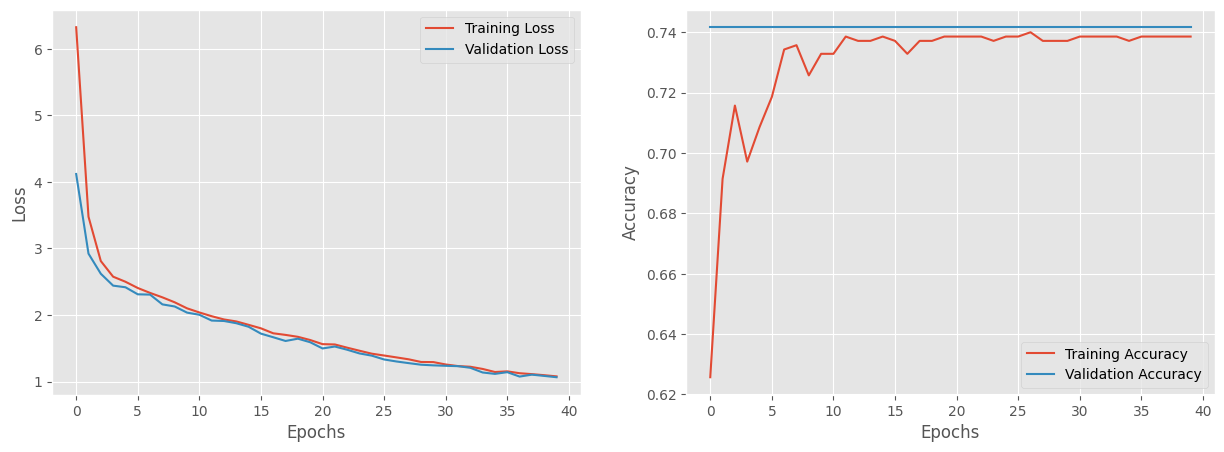

In [22]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist2.history["loss"], label = "Training Loss")
plt.plot( hist2.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist2.history["accuracy"], label = "Training Accuracy")
plt.plot( hist2.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [23]:
model_resnet.evaluate(x_test,y_test)

6/6 [==============================] - 15s 3s/step - loss: 1.0676 - accuracy: 0.7389


[1.067570447921753, 0.7388888597488403]

In [24]:
predictions = model_resnet.predict(x_test, batch_size = 32)
pred2 = np.argmax(predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)

6/6 [==============================] - 16s 2s/step


In [25]:
print(classification_report(y_test2, pred2))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85       133
           1       0.00      0.00      0.00        47

    accuracy                           0.74       180
   macro avg       0.37      0.50      0.42       180
weighted avg       0.55      0.74      0.63       180



C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(confusion_matrix(y_test2, pred2))

[[133   0]
 [ 47   0]]


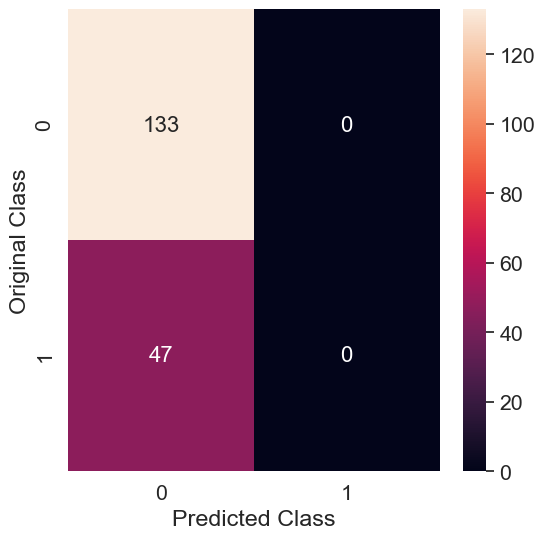

In [27]:
plt.figure(figsize=(6,6))
df_cm2 = pd.DataFrame(confusion_matrix(y_test2, pred2), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm2, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [28]:
y_pred_keras2 = model_resnet.predict(x_test).ravel()

6/6 [==============================] - 15s 2s/step


In [29]:
from sklearn.metrics import roc_curve

fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test2, pred2)

In [30]:
from sklearn.metrics import auc
auc_keras2 = auc(fpr_keras2, tpr_keras2)

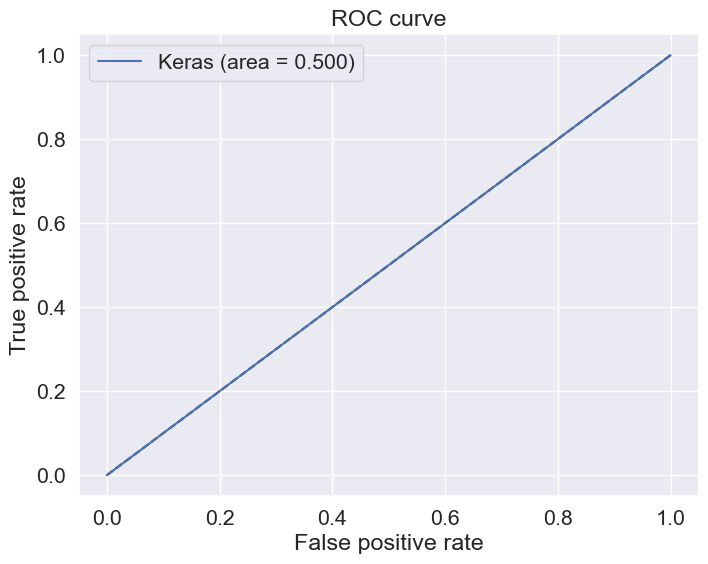

In [31]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras2, tpr_keras2, label='Keras (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [32]:
model1 = InceptionV3(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

In [33]:
model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 264, 264, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 131, 131, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 131, 131, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 131, 131, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 30, 30, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 30, 30, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 30, 30, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 30, 30, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 30, 30, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 30, 30, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 30, 30, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 30, 30, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 30, 30, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 30, 30, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 14, 14, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 14, 14, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 14, 14, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 14, 14, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 14, 14, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 14, 14, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 14, 14, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 14, 14, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 14, 14, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 14, 14, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 14, 14, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 14, 14, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 14, 14, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 14, 14, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 14, 14, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 14, 14, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 14, 14, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 6, 6, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 6, 6, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 6, 6, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 6, 6, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 6, 6, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [34]:
for ix in range(len(model1.layers)):
    print(ix,model1.layers[ix])

0 <keras.src.engine.input_layer.InputLayer object at 0x000002A5162F05E0>
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A5152FEFD0>
2 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A51526DF40>
3 <keras.src.layers.core.activation.Activation object at 0x000002A514F68F40>
4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A514E9C280>
5 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A51526D190>
6 <keras.src.layers.core.activation.Activation object at 0x000002A5163531F0>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516353790>
8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A514DEB790>
9 <keras.src.layers.core.activation.Activation object at 0x000002A515300EE0>
10 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002A515300EB0>
11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002

150 <keras.src.layers.core.activation.Activation object at 0x000002A516AFE5E0>
151 <keras.src.layers.pooling.average_pooling2d.AveragePooling2D object at 0x000002A516B0CA90>
152 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516AB0EE0>
153 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516AB0670>
154 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516AECF40>
155 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516AFEE50>
156 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A516AD1A90>
157 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A5165EA8B0>
158 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A516AF5490>
159 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A516AFE940>
160 <keras.src.layers.core.activation.Activation object at 0x000002A516AC1DC0>
161 <ke

269 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A516C780D0>
270 <keras.src.layers.core.activation.Activation object at 0x000002A516C2E910>
271 <keras.src.layers.core.activation.Activation object at 0x000002A516C78A90>
272 <keras.src.layers.core.activation.Activation object at 0x000002A516CA44F0>
273 <keras.src.layers.core.activation.Activation object at 0x000002A516CABAF0>
274 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000002A516CBA160>
275 <keras.src.layers.core.activation.Activation object at 0x000002A516C58C40>
276 <keras.src.layers.merging.concatenate.Concatenate object at 0x000002A516B93C40>
277 <keras.src.layers.merging.concatenate.Concatenate object at 0x000002A516CABA60>
278 <keras.src.layers.core.activation.Activation object at 0x000002A516CB0670>
279 <keras.src.layers.merging.concatenate.Concatenate object at 0x000002A516CBA1F0>
280 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00

In [35]:
for layer in model1.layers[:299]:
    layer.trainable = False
for i, layer in enumerate(model1.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [36]:
av1 = Flatten()(model1.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_incep = Model(model1.input,fc3)
model_incep.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 264, 264, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 131, 131, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 131, 131, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 131, 131, 32)         0         ['batch_normalization[0]

 conv2d_11 (Conv2D)          (None, 30, 30, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 30, 30, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 30, 30, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 30, 30, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 30, 30, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 30, 30, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 30, 30, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 30, 30, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 30, 30, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 30, 30, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 14, 14, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 14, 14, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 14, 14, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 14, 14, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 14, 14, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 14, 14, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 14, 14, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 14, 14, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 14, 14, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 14, 14, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 14, 14, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 14, 14, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 14, 14, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 14, 14, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 14, 14, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 14, 14, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 14, 14, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 6, 6, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 6, 6, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 6, 6, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 6, 6, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 6, 6, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [37]:
adam = Adam(learning_rate=0.0001)
model_incep.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [38]:
filepath="retina_incep.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [39]:
hist3 = model_incep.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 25,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 7.5547 - accuracy: 0.6529
Epoch 1: val_loss improved from inf to 6.57139, saving model to retina_incep.hdf5


C:\Anaconda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 52s 2s/step - loss: 7.5547 - accuracy: 0.6529 - val_loss: 6.5714 - val_accuracy: 0.7417
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 6.3445 - accuracy: 0.7029
Epoch 2: val_loss improved from 6.57139 to 5.86285, saving model to retina_incep.hdf5
22/22 [==============================] - 47s 2s/step - loss: 6.3445 - accuracy: 0.7029 - val_loss: 5.8629 - val_accuracy: 0.7417
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 5.6154 - accuracy: 0.7043
Epoch 3: val_loss improved from 5.86285 to 5.28008, saving model to retina_incep.hdf5
22/22 [==============================] - 48s 2s/step - loss: 5.6154 - accuracy: 0.7043 - val_loss: 5.2801 - val_accuracy: 0.7417
Epoch 4/25
22/22 [==============================] - ETA: 0s - loss: 5.0947 - accuracy: 0.7386
Epoch 4: val_loss improved from 5.28008 to 4.86706, saving model to retina_incep.hdf5
22/22 [==============================] - 48s 2s/step - loss: 5.0947 - acc

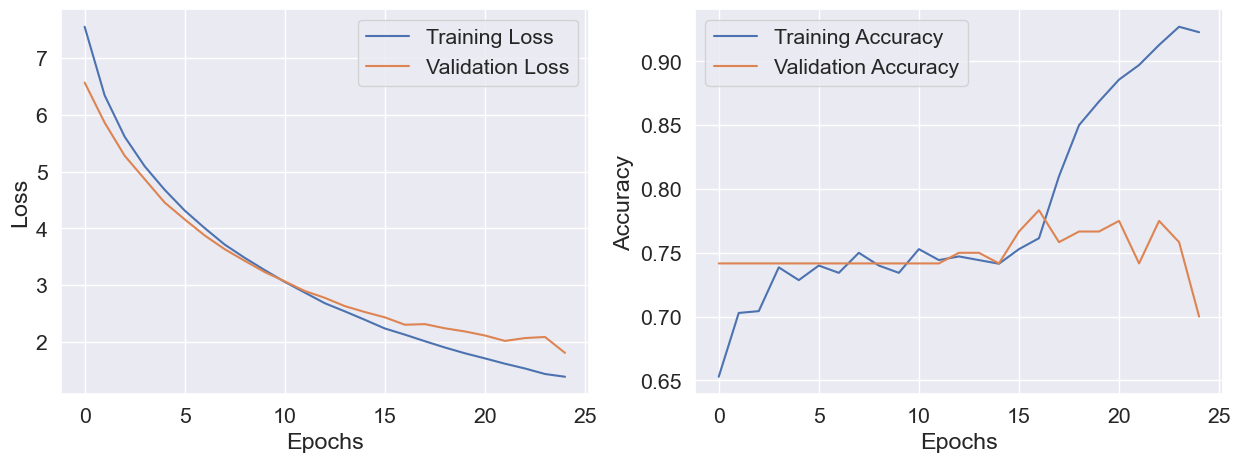

In [40]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist3.history["loss"], label = "Training Loss")
plt.plot( hist3.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist3.history["accuracy"], label = "Training Accuracy")
plt.plot( hist3.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [41]:
model_incep.evaluate(x_test,y_test)

6/6 [==============================] - 9s 2s/step - loss: 1.9023 - accuracy: 0.7056


[1.9023325443267822, 0.7055555582046509]

In [42]:
predictions3 = model_incep.predict(x_test, batch_size = 32)
pred3 = np.argmax(predictions3, axis=1)
y_test3 = np.argmax(y_test, axis=1)

6/6 [==============================] - 11s 2s/step


In [43]:
print(classification_report(y_test3, pred3))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       133
           1       0.40      0.26      0.31        47

    accuracy                           0.71       180
   macro avg       0.58      0.56      0.56       180
weighted avg       0.67      0.71      0.68       180



In [44]:
print(confusion_matrix(y_test3, pred3))

[[115  18]
 [ 35  12]]


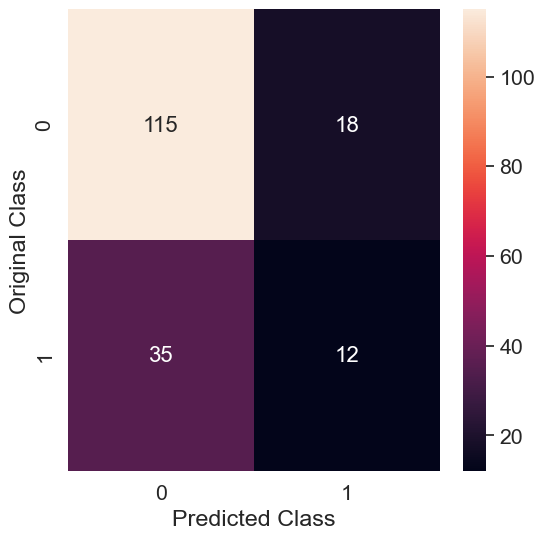

In [45]:
plt.figure(figsize=(6,6))
df_cm3 = pd.DataFrame(confusion_matrix(y_test3, pred3), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm3, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [46]:
y_pred_keras3 = model_incep.predict(x_test).ravel()

6/6 [==============================] - 11s 2s/step


In [47]:
from sklearn.metrics import roc_curve

fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test3, pred3)

In [48]:
from sklearn.metrics import auc
auc_keras3 = auc(fpr_keras3, tpr_keras3)

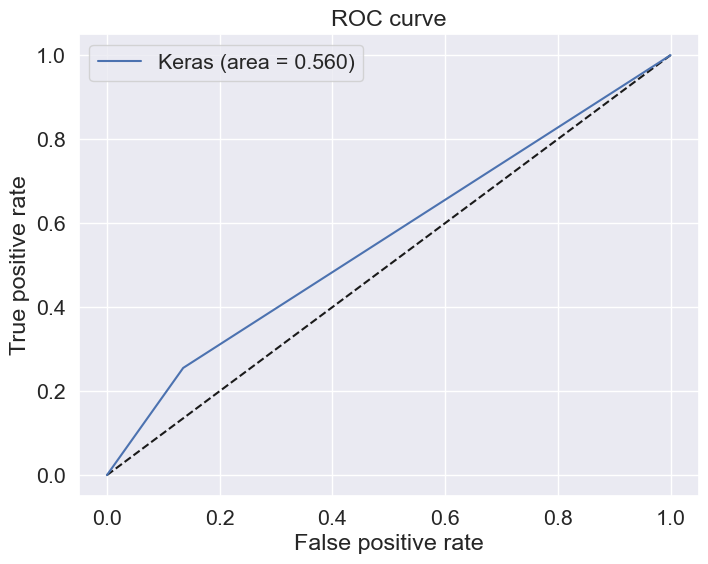

In [49]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [50]:
model2 = VGG16(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

In [51]:
model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 264, 264, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 264, 264, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 264, 264, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 132, 132, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 132, 132, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 132, 132, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 66, 66, 128)       0     

In [52]:
for ix in range(len(model2.layers)):
    print(ix,model2.layers[ix])

0 <keras.src.engine.input_layer.InputLayer object at 0x000002A516A293D0>
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516A295E0>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516CABA30>
3 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002A516F24AF0>
4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516A6E5B0>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A51FAAC880>
6 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002A516F24910>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516F38B20>
8 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516F19550>
9 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516F4CB50>
10 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002A516F4C880>
11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002A516F4CF10>
12 <keras.src.layers.convolutional.conv2d.Conv

In [53]:
for layer in model2.layers[:16]:
    layer.trainable = False
for i, layer in enumerate(model2.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [54]:
av1 = Flatten()(model2.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)

In [55]:
model_vgg16 = Model(model2.input,fc3)
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 264, 264, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 264, 264, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 264, 264, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 132, 132, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 132, 132, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 132, 132, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 66, 66, 128)       0   

In [56]:
adam = Adam(learning_rate=0.0001)
model_vgg16.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [57]:
filepath="retina_vgg16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [58]:
hist1 = model_vgg16.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 20,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 6.5872 - accuracy: 0.7214
Epoch 1: val_loss improved from inf to 5.69390, saving model to retina_vgg16.hdf5


C:\Anaconda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 243s 11s/step - loss: 6.5872 - accuracy: 0.7214 - val_loss: 5.6939 - val_accuracy: 0.7417
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 5.0898 - accuracy: 0.7314
Epoch 2: val_loss improved from 5.69390 to 4.47241, saving model to retina_vgg16.hdf5
22/22 [==============================] - 197s 9s/step - loss: 5.0898 - accuracy: 0.7314 - val_loss: 4.4724 - val_accuracy: 0.7417
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 4.0768 - accuracy: 0.7371
Epoch 3: val_loss improved from 4.47241 to 3.64816, saving model to retina_vgg16.hdf5
22/22 [==============================] - 199s 9s/step - loss: 4.0768 - accuracy: 0.7371 - val_loss: 3.6482 - val_accuracy: 0.7417
Epoch 4/20
22/22 [==============================] - ETA: 0s - loss: 3.3888 - accuracy: 0.7386
Epoch 4: val_loss improved from 3.64816 to 3.12514, saving model to retina_vgg16.hdf5
22/22 [==============================] - 212s 10s/step - loss: 3.3888

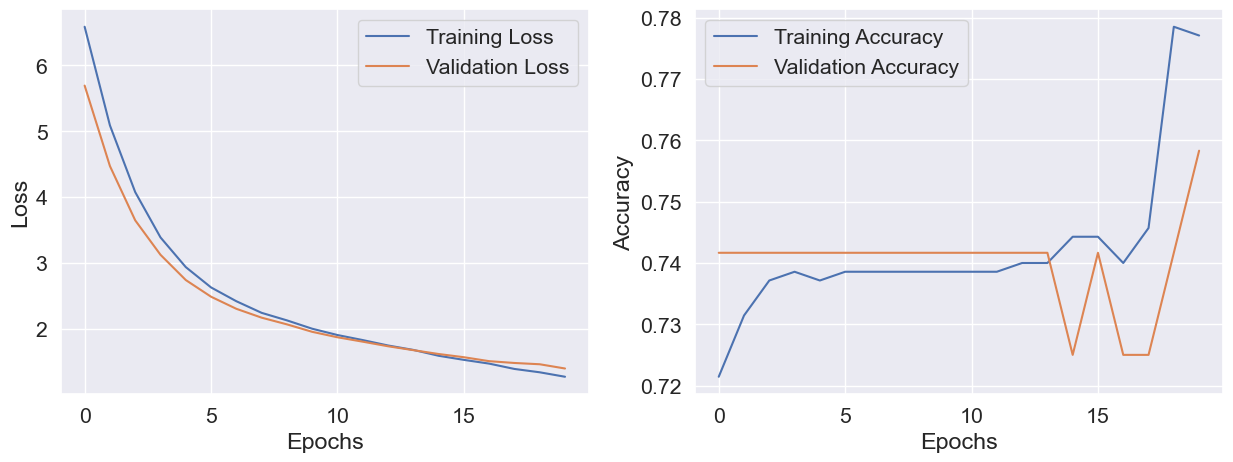

In [59]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist1.history["loss"], label = "Training Loss")
plt.plot( hist1.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist1.history["accuracy"], label = "Training Accuracy")
plt.plot( hist1.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [60]:
model_vgg16.evaluate(x_test,y_test)

6/6 [==============================] - 43s 7s/step - loss: 1.4145 - accuracy: 0.7056


[1.4144892692565918, 0.7055555582046509]

In [61]:
predictions = model_vgg16.predict(x_test, batch_size = 32)
pred1 = np.argmax(predictions, axis=1)
y_test1 = np.argmax(y_test, axis=1)

6/6 [==============================] - 39s 6s/step


In [62]:
print(classification_report(y_test1, pred1))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82       133
           1       0.25      0.06      0.10        47

    accuracy                           0.71       180
   macro avg       0.49      0.50      0.46       180
weighted avg       0.61      0.71      0.64       180



In [63]:
print(confusion_matrix(y_test1, pred1))

[[124   9]
 [ 44   3]]


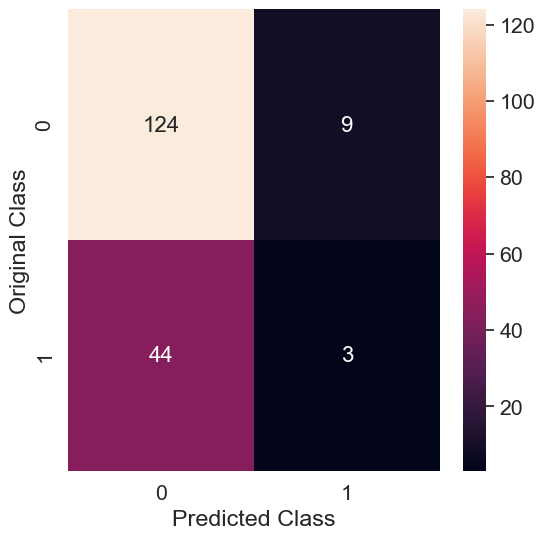

In [64]:
plt.figure(figsize=(6,6))
df_cm1 = pd.DataFrame(confusion_matrix(y_test1, pred1), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [65]:
y_pred_keras1 = model_vgg16.predict(x_test).ravel()

6/6 [==============================] - 38s 6s/step


In [66]:
from sklearn.metrics import roc_curve

fpr_keras1, tpr_keras1, thresholds_keras1 = roc_curve(y_test1, pred1)

In [67]:
from sklearn.metrics import auc
auc_keras1 = auc(fpr_keras1, tpr_keras1)

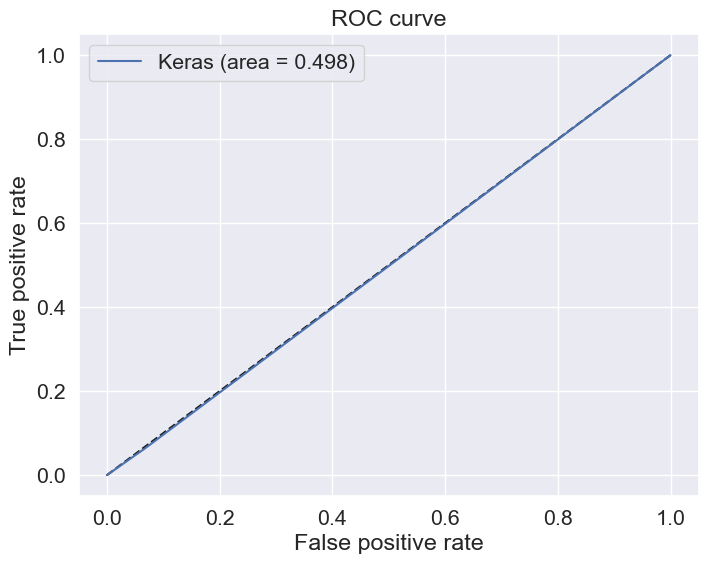

In [68]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras1, tpr_keras1, label='Keras (area = {:.3f})'.format(auc_keras1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [69]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

NameError: name 'Sequential' is not defined

In [ ]:
c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=100,batch_size=16,validation_split=0.3)

In [ ]:
y_test=np.argmax(y_test, axis=1)
pred=np.argmax(model.predict(x_test),axis=-1)
cm=confusion_matrix(y_test,pred)
cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

In [ ]:
print("Performance Report:")
y_pred=np.argmax(model.predict(x_test),axis=-1)
Y_test=to_categorical(y_test,5)
y_pred_prb=model.predict(x_test)
target=['0','1']
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, y_pred))
print('Precision score is :', metrics.precision_score(y_test, y_pred, average='weighted'))
print('Recall score is :',metrics.recall_score(y_test,y_pred, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, y_pred,average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, y_pred))
print('\t\tClassification Report:\n', metrics.classification_report(y_test,pred,target_names=target))

In [ ]:
model.save_weights("model3.h5")